In [ ]:
# Credit One Classification

### Preliminary notes:


#### 1- Liblinear solver will be used to avoid the warnings of Logistic Regression
####   "LIBLINEAR is the winner of ICML 2008 large-scale learning challenge.
####    It applies Automatic parameter selection (a.k.a L1 Regularization)
####    and it’s recommended when you have high dimension dataset (recommended
####    for solving large-scale classification problems)"
####
#### *Source: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions

#### 2- Approximate training times (in seconds) for the models were:
####   LR:   5s    [0.821238 || 0.011387]
####   KNN:  7s    [0.796667 || 0.012368]
####   CART: 2s    [0.749238 || 0.009308] 
####   NB:   1s    [0.788571 || 0.013335]
####   SVM:  325s  [0.819714 || 0.011717]

#### 3- Used random_state=14 as the random seed generator throughout the project

#### 4-The three final selected models all yield the same accuracy of 0.81

In [1]:
##Import libraries

import time

#Numpy,Pandas, Scipy, Math, and matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
from matplotlib import pyplot
import matplotlib as plt


#Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

#Estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#Model metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score

#Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV

#Pickle (to save the models)
from pickle import dump
from pickle import load

In [2]:
# Import the data
rawData = pd.read_csv(r'C:\Alejandro\Big Data & Data Analytics\Course 5 - Python\Task 2 - Prepare and Explore the Data\CLEAN credit card clients.csv')
rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,Female,2,Married,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,Yes
1,120000,Female,2,Single,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Yes
2,90000,Female,2,Single,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,No
3,50000,Female,2,Married,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,No
4,50000,Male,2,Married,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,No


In [3]:
#Check the data structure
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null object
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null object
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null object
dtypes: int64(21), object(3)
memory usage: 5.5+ MB


In [4]:
##DATA CLEANING AND PRE-PROCESSING

# Drop collinear features BILL_AMT2, BILL_AMT4 & BILL_AMT5, previously identified
# during the Exploratory Data Analysis.

CleanData = rawData.drop(['BILL_AMT2', 'BILL_AMT4', 'BILL_AMT5'], axis=1)
print('\nDropped collinear features BILL_AMT2, BILL_AMT4, and BILL_AMT5\n')
CleanData.head()


Dropped collinear features BILL_AMT2, BILL_AMT4, and BILL_AMT5



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,Female,2,Married,24,2,2,-1,-1,-2,...,3913,689,0,0,689,0,0,0,0,Yes
1,120000,Female,2,Single,26,-1,2,0,0,0,...,2682,2682,3261,0,1000,1000,1000,0,2000,Yes
2,90000,Female,2,Single,34,0,0,0,0,0,...,29239,13559,15549,1518,1500,1000,1000,1000,5000,No
3,50000,Female,2,Married,37,0,0,0,0,0,...,46990,49291,29547,2000,2019,1200,1100,1069,1000,No
4,50000,Male,2,Married,57,-1,0,-1,0,0,...,8617,35835,19131,2000,36681,10000,9000,689,679,No


In [5]:
# Verify the columns were dropped and check the variable types
print('\n New data frame\n')
CleanData.info()


 New data frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 21 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null object
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null object
AGE          30000 non-null int64
PAY_1        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null object
dtypes: int64(18), object(3)
memory usage: 4.8+ MB


In [6]:
##Manage redundant variables

print('****************************************************',
      '\nOriginal possible values for EDUCATION and PAY_1',
     '\n****************************************************\n')
#Check the values in EDUCATION
print(CleanData.groupby('EDUCATION')['EDUCATION'].nunique(),'\n')

#Check the values in PAY_1 (as a sample of PAY_#)
print(CleanData.groupby('PAY_1')['PAY_1'].nunique())

**************************************************** 
Original possible values for EDUCATION and PAY_1 
****************************************************

EDUCATION
0    1
1    1
2    1
3    1
4    1
5    1
6    1
Name: EDUCATION, dtype: int64 

PAY_1
-2    1
-1    1
 0    1
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 7    1
 8    1
Name: PAY_1, dtype: int64


In [7]:
# For PAY_#, a value of -2 means "No consumption" and a -1 means "Paid in full",
# both of which mean no balance due. Hence, we will merge these two as -1,
# which will now represent "No balance due".

for i in range(1,7):
    CleanData.loc[CleanData["PAY_" + str(i)] < 0, "PAY_" + str(i)] = -1

In [8]:
# For EDUCATION, the values of 0, 4, 5, 6 all represent the same: 'others'.
# Hence, these will all be merged into '4'.

replace = (CleanData["EDUCATION"] == 0) | (CleanData["EDUCATION"] == 5) | (CleanData["EDUCATION"] == 6) 
CleanData.loc[replace,'EDUCATION'] = 4

In [9]:
#Check the values in EDUCATION
print('*****************************************',
      '\nModified values for EDUCATION and PAY_1',
     '\n*****************************************\n')

print(CleanData.groupby('EDUCATION')['EDUCATION'].nunique(),'\n')

#Check the values in PAY_1 (as a sample of PAY_X)
print(CleanData.groupby('PAY_1')['PAY_1'].nunique())

#'EDUCATION' was successfully reduced from [0,1,2,3,4,5,6] to [1,2,3,4]
#'PAY_#' was successfully reduced from [-2,-1,0,1,2,3,4,5,6,7,8] to [-1,0,1,2,3,4,5,6,7,8]

***************************************** 
Modified values for EDUCATION and PAY_1 
*****************************************

EDUCATION
1    1
2    1
3    1
4    1
Name: EDUCATION, dtype: int64 

PAY_1
-1    1
 0    1
 1    1
 2    1
 3    1
 4    1
 5    1
 6    1
 7    1
 8    1
Name: PAY_1, dtype: int64


In [10]:
#Check information on the resulting dataframe. Check Min/Max for 'PAY_X' & 'EDUCATION'
CleanData.describe()

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.842267,35.485500,0.075267,-0.007700,-0.030033,-0.075733,-0.114667,-0.127933,51223.330900,4.701315e+04,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,0.744494,9.217904,0.990775,1.035798,1.025036,0.987436,0.941921,0.949384,73635.860576,6.934939e+04,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,1.000000,21.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-165580.000000,-1.572640e+05,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2.666250e+03,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,2.008850e+04,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,6.016475e+04,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,4.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,1.664089e+06,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [11]:
# change variable types
CleanData['SEX'] = CleanData['SEX'].astype('category')
CleanData['EDUCATION'] = CleanData['EDUCATION'].astype('category')
CleanData['MARRIAGE'] = CleanData['MARRIAGE'].astype('category')
CleanData['PAY_1'] = CleanData['PAY_1'].astype('category')
CleanData['PAY_2'] = CleanData['PAY_2'].astype('category')
CleanData['PAY_3'] = CleanData['PAY_3'].astype('category')
CleanData['PAY_4'] = CleanData['PAY_4'].astype('category')
CleanData['PAY_5'] = CleanData['PAY_5'].astype('category')
CleanData['PAY_6'] = CleanData['PAY_6'].astype('category')
CleanData['default'] = CleanData['default'].astype('category')
print('\nCategorical features have been successfully converted to category dtype\n')
CleanData.info()


Categorical features have been successfully converted to category dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 21 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null category
EDUCATION    30000 non-null category
MARRIAGE     30000 non-null category
AGE          30000 non-null int64
PAY_1        30000 non-null category
PAY_2        30000 non-null category
PAY_3        30000 non-null category
PAY_4        30000 non-null category
PAY_5        30000 non-null category
PAY_6        30000 non-null category
BILL_AMT1    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null category
dtypes: category(10), int64(11)
memory usage: 2.8 MB


In [12]:
# Separate the numerical features

NumFeat=CleanData.loc[:,['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT3','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]
print('\nNumerical Features')
NumFeat.head()


Numerical Features


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,24,3913,689,0,0,689,0,0,0,0
1,120000,26,2682,2682,3261,0,1000,1000,1000,0,2000
2,90000,34,29239,13559,15549,1518,1500,1000,1000,1000,5000
3,50000,37,46990,49291,29547,2000,2019,1200,1100,1069,1000
4,50000,57,8617,35835,19131,2000,36681,10000,9000,689,679


In [13]:
#Separate the categorical features
CatFeat = CleanData.drop(NumFeat.columns, axis=1)
CatFeat = CatFeat.drop('default', axis=1)
print('\nCategorical Features')
CatFeat.head()


Categorical Features


,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,Female,2,Married,2,2,-1,-1,-1,-1
1,Female,2,Single,-1,2,0,0,0,2
2,Female,2,Single,0,0,0,0,0,0
3,Female,2,Married,0,0,0,0,0,0
4,Male,2,Married,-1,0,-1,0,0,0


In [14]:
# Get the target variable

Target=CleanData.loc[:,['default']]
print('\nResponse Variable')
Target.head(10)


Response Variable


,default
0,Yes
1,Yes
2,No
3,No
4,No
5,No
6,No
7,No
8,No
9,No


In [15]:
# Standardize the numerical features

scaler = StandardScaler()
StdNumFeat = scaler.fit_transform(NumFeat)
StdNumFeat= pd.DataFrame(StdNumFeat)
StdNumFeat.columns = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT3','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
print('\nStandardized Numerical Features')
StdNumFeat.head()


Standardized Numerical Features


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,-1.246020,-0.642501,-0.667993,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,-1.029047,-0.659219,-0.639254,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,-0.161156,-0.298560,-0.482408,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.164303,-0.057491,0.032846,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,2.334029,-0.578618,-0.161189,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


In [16]:
##ONE HOT ENCODING

#Dummify the categorical data
DumData = pd.get_dummies(CatFeat)
print('\nOne-hot-encoded Categorical Features\n')
DumData.info()


One-hot-encoded Categorical Features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 68 columns):
SEX_Female           30000 non-null uint8
SEX_Male             30000 non-null uint8
EDUCATION_1          30000 non-null uint8
EDUCATION_2          30000 non-null uint8
EDUCATION_3          30000 non-null uint8
EDUCATION_4          30000 non-null uint8
MARRIAGE_Divorced    30000 non-null uint8
MARRIAGE_Married     30000 non-null uint8
MARRIAGE_Other       30000 non-null uint8
MARRIAGE_Single      30000 non-null uint8
PAY_1_-1             30000 non-null uint8
PAY_1_0              30000 non-null uint8
PAY_1_1              30000 non-null uint8
PAY_1_2              30000 non-null uint8
PAY_1_3              30000 non-null uint8
PAY_1_4              30000 non-null uint8
PAY_1_5              30000 non-null uint8
PAY_1_6              30000 non-null uint8
PAY_1_7              30000 non-null uint8
PAY_1_8              30000 non-null uint8
PAY_2_-1    

In [17]:
#Put together the full working dataframe by concatenating the standardized
#numerical features, the dummified categorical features, and the response variable.

credit_df = pd.concat([StdNumFeat, DumData, Target], axis=1)
print('*******************',
      '\n Cleaned Dataframe',
     '\n*******************')
credit_df.head()

******************* 
 Cleaned Dataframe 
*******************


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,...,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,-1.136720,-1.246020,-0.642501,-0.667993,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,...,1,0,0,0,0,0,0,0,0,Yes
1,-0.365981,-1.029047,-0.659219,-0.639254,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,...,0,0,1,0,0,0,0,0,0,Yes
2,-0.597202,-0.161156,-0.298560,-0.482408,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,...,0,1,0,0,0,0,0,0,0,No
3,-0.905498,0.164303,-0.057491,0.032846,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,...,0,1,0,0,0,0,0,0,0,No
4,-0.905498,2.334029,-0.578618,-0.161189,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,...,0,1,0,0,0,0,0,0,0,No


In [19]:
#Check the new data structure

print('****************************',
      '\n Cleaned Dataframe Structure',
     '\n****************************\n')

credit_df.info()

**************************** 
 Cleaned Dataframe Structure 
****************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 80 columns):
LIMIT_BAL            30000 non-null float64
AGE                  30000 non-null float64
BILL_AMT1            30000 non-null float64
BILL_AMT3            30000 non-null float64
BILL_AMT6            30000 non-null float64
PAY_AMT1             30000 non-null float64
PAY_AMT2             30000 non-null float64
PAY_AMT3             30000 non-null float64
PAY_AMT4             30000 non-null float64
PAY_AMT5             30000 non-null float64
PAY_AMT6             30000 non-null float64
SEX_Female           30000 non-null uint8
SEX_Male             30000 non-null uint8
EDUCATION_1          30000 non-null uint8
EDUCATION_2          30000 non-null uint8
EDUCATION_3          30000 non-null uint8
EDUCATION_4          30000 non-null uint8
MARRIAGE_Divorced    30000 non-null uint8
MARRIAGE_Married     30

In [20]:
#Select the independent variables (features)
Features = credit_df.iloc[:,0:-1]
print('Sample of cleaned Features')
Features.head(10)


Sample of cleaned Features


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT3,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,-1.136720,-1.246020,-0.642501,-0.667993,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,...,0,1,0,0,0,0,0,0,0,0
1,-0.365981,-1.029047,-0.659219,-0.639254,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,...,0,0,0,1,0,0,0,0,0,0
2,-0.597202,-0.161156,-0.298560,-0.482408,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,...,0,0,1,0,0,0,0,0,0,0
3,-0.905498,0.164303,-0.057491,0.032846,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,...,0,0,1,0,0,0,0,0,0,0
4,-0.905498,2.334029,-0.578618,-0.161189,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,...,0,0,1,0,0,0,0,0,0,0
5,-0.905498,0.164303,0.178947,0.152777,-0.316487,-0.191003,-0.178215,-0.259486,-0.244230,-0.248683,...,0,0,1,0,0,0,0,0,0,0
6,2.562830,-0.703588,4.301531,5.739063,7.305617,2.978712,1.479085,1.861472,0.983852,0.585848,...,0,0,1,0,0,0,0,0,0,0
7,-0.520128,-1.354506,-0.534359,-0.669262,-0.643203,-0.318999,-0.230905,-0.296801,-0.270976,-0.203716,...,0,1,0,0,0,0,0,0,0,0
8,-0.211833,-0.812074,-0.542385,-0.503332,-0.590276,-0.140952,-0.256990,-0.272265,-0.244230,-0.248683,...,0,0,1,0,0,0,0,0,0,0
9,-1.136720,-0.052670,-0.695642,-0.677929,-0.419118,-0.341942,-0.256990,-0.296801,0.522212,-0.240697,...,0,1,0,0,0,0,0,0,0,0


In [21]:
#Select the dependent variable
#Target = credit_df.iloc[:,88:90]
print('Target Variable')
Target.head(10)

Target Variable


,default
0,Yes
1,Yes
2,No
3,No
4,No
5,No
6,No
7,No
8,No
9,No


In [23]:
##FEATURE ENGINEERING

#Recursive Feature Elimination
model = LogisticRegression(solver='liblinear', random_state=14)
rfe = RFE(model)
rfem = rfe.fit(Features, Target.values.ravel()) #use the ravel() function as suggested by warning
print("Number of Features: %d" % rfem.n_features_)
print("\nSelected Features: %s" % rfem.support_)
print("\nFeature Ranking: %s" % rfem.ranking_)

Number of Features: 39

Selected Features: [ True False False False False False  True False False False False False
 False False False False  True False False  True False  True  True  True
  True  True  True False  True  True False  True False  True False False
  True  True  True  True  True False False False  True  True False  True
  True  True False False False  True  True False  True  True  True False
  True  True  True False False  True False  True  True False False  True
 False  True False False  True False  True]

Feature Ranking: [ 1 34 40  9 26  8  1 36 33 30 29 11 35  4  2  3  1  5  6  1 22  1  1  1
  1  1  1 14  1  1 21  1 25  1 32 31  1  1  1  1  1 23 24 28  1  1 20  1
  1  1 10 39 41  1  1 13  1  1  1 38  1  1  1 27 12  1 37  1  1  7 16  1
 19  1 18 17  1 15  1]


In [24]:
# Create the reduced dataset according to the RFE selected features
redFeat = Features.loc[:,[True, False, False, False, False, False, True, False, False, False, False, False,
                        False, False, False, False, True, False, False, True, False, True, True, True,
                        True, True, True, False, True, True, False, True, False, True, False, False,
                        True, True, True, True, True, False, False, False, True, True, False, True,
                        True, True, False, False, False, True, True, False, True, True, True, False,
                        True, True, True, False, False, True, False, True, True, False, False, True,
                        False, True, False, False, True, False, True]]
print('\nReduced features using RFE')
redFeat.head(10)


Reduced features using RFE


,LIMIT_BAL,PAY_AMT2,EDUCATION_4,MARRIAGE_Other,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,...,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_4,PAY_5_6,PAY_5_7,PAY_6_0,PAY_6_3,PAY_6_6,PAY_6_8
0,-1.136720,-0.227086,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.365981,-0.213588,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-0.597202,-0.191887,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,-0.905498,-0.169361,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,-0.905498,1.335034,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,-0.905498,-0.178215,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6,2.562830,1.479085,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7,-0.520128,-0.230905,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,-0.211833,-0.256990,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9,-1.136720,-0.256990,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
#Check the RFE reduced features dataset

print('\nReduced features using RFE\n')
redFeat.info()


Reduced features using RFE

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 39 columns):
LIMIT_BAL         30000 non-null float64
PAY_AMT2          30000 non-null float64
EDUCATION_4       30000 non-null uint8
MARRIAGE_Other    30000 non-null uint8
PAY_1_-1          30000 non-null uint8
PAY_1_0           30000 non-null uint8
PAY_1_1           30000 non-null uint8
PAY_1_2           30000 non-null uint8
PAY_1_3           30000 non-null uint8
PAY_1_4           30000 non-null uint8
PAY_1_6           30000 non-null uint8
PAY_1_7           30000 non-null uint8
PAY_2_-1          30000 non-null uint8
PAY_2_1           30000 non-null uint8
PAY_2_4           30000 non-null uint8
PAY_2_5           30000 non-null uint8
PAY_2_6           30000 non-null uint8
PAY_2_7           30000 non-null uint8
PAY_2_8           30000 non-null uint8
PAY_3_2           30000 non-null uint8
PAY_3_3           30000 non-null uint8
PAY_3_5           30000 non-null uint8


In [26]:
## CLASSIFICATION

#Create the arrays with the features (X1) and the target (Y) values
X1=redFeat.values
Y = Target.values

In [27]:
# Create training (70%) and test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X1,Y,test_size=0.3,random_state=14)

In [28]:
# Prepare models and estimate their accuracy

models = []
models.append(('RF', RandomForestClassifier(n_estimators=50)))
models.append(('GBT', GradientBoostingClassifier(n_estimators=50)))
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

print('\nCross-validation Scores for different algorithms:\n')

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=14)
    cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    res = "%s: %f || %f" % (name, cv_results.mean(), cv_results.std())
    print(res)


Cross-validation Scores for different algorithms:

RF: 0.783381 || 0.006485
GBT: 0.823000 || 0.008248
LR: 0.822714 || 0.008118
KNN: 0.797762 || 0.008679
CART: 0.754381 || 0.007731
NB: 0.798048 || 0.011081
SVM: 0.822143 || 0.008773


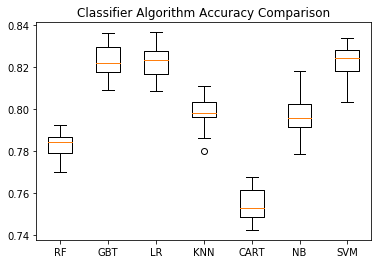

In [29]:
# Compare algorithms using a boxplot chart

pyplot.boxplot(results, labels=names)
pyplot.title('Classifier Algorithm Accuracy Comparison')
pyplot.show()

In [30]:
## MODEL TUNING

# According to the results from the cross-validation scores obtained, the top
# three models are Logistic Regression, Gradient Boosted Trees, and SVM.

# Stochastic Gradient Boosting Classification tuning
t0 = time.time() #begin time keeper variable

tune_grid = dict(n_estimators=np.array([50,100,150,200,250]),learning_rate=np.array([0.001, 0.01, 0.1]))
tGBTmodel = GradientBoostingClassifier(random_state=14)
kfold = KFold(n_splits=10, random_state=14)
gbt_cv = GridSearchCV(estimator=tGBTmodel, param_grid=tune_grid, scoring='accuracy', cv=kfold)
tGBTresult = gbt_cv.fit(X_train, y_train.ravel())

ttt = time.time() - t0 #ttt stands for "time to train"

#Save the fitted model to disk
cvGBTfilename = 'cvGBTmodel.sav'
dump(gbt_cv, open(cvGBTfilename, 'wb'))
print("\n*** The fitted model has been successfully saved as %s ***" % cvGBTfilename)


print("It takes: %.2f seconds for GBT Classifier tuning" % ttt)
print("\nBest: %f using %s" % (tGBTresult.best_score_, tGBTresult.best_params_))
means = tGBTresult.cv_results_['mean_test_score']
stds = tGBTresult.cv_results_['std_test_score']
params = tGBTresult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


*** The fitted model has been successfully saved as cvGBTmodel.sav ***
It takes: 672.82 seconds for GBT Classifier tuning

Best: 0.823000 using {'learning_rate': 0.1, 'n_estimators': 50}
0.782571 (0.005691) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.782571 (0.005691) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.782571 (0.005691) with: {'learning_rate': 0.001, 'n_estimators': 150}
0.782571 (0.005691) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.782571 (0.005691) with: {'learning_rate': 0.001, 'n_estimators': 250}
0.782571 (0.005691) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.819000 (0.007006) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.820667 (0.008254) with: {'learning_rate': 0.01, 'n_estimators': 150}
0.821333 (0.008502) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.822286 (0.008870) with: {'learning_rate': 0.01, 'n_estimators': 250}
0.823000 (0.008248) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.822810 (0.008277) with: {'le

In [31]:
# LogisticRegression Algorithm tuning

t0 = time.time() #begin time keeper variable

c_space = [0.1,1,10,50,100]
LRtune_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
tLRmodel = LogisticRegression(solver='liblinear', random_state=14)
kfold = KFold(n_splits=10, random_state=14)
logreg_cv = GridSearchCV(estimator=tLRmodel, param_grid=LRtune_grid, scoring='accuracy', cv=kfold)
tLRresult=logreg_cv.fit(X_train, y_train.ravel())

ttt = time.time() - t0 #ttt stands for "time to train"

#Save the fitted model to disk
cvLRfilename = 'cvLRmodel.sav'
dump(logreg_cv, open(cvLRfilename, 'wb'))
print("\n*** The fitted model has been successfully saved as %s ***" % cvLRfilename)

print("It takes: %.2f seconds for Logistic Regression Classifier tuning" % ttt)
print("\nBest: %f using %s" % (tLRresult.best_score_, tLRresult.best_params_))
means = tLRresult.cv_results_['mean_test_score']
stds = tLRresult.cv_results_['std_test_score']
params = tLRresult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


*** The fitted model has been successfully saved as cvLRmodel.sav ***
It takes: 15.95 seconds for Logistic Regression Classifier tuning

Best: 0.822952 using {'C': 50, 'penalty': 'l1'}
0.821810 (0.007780) with: {'C': 0.1, 'penalty': 'l1'}
0.822524 (0.008073) with: {'C': 0.1, 'penalty': 'l2'}
0.822619 (0.008017) with: {'C': 1, 'penalty': 'l1'}
0.822714 (0.008118) with: {'C': 1, 'penalty': 'l2'}
0.822905 (0.007981) with: {'C': 10, 'penalty': 'l1'}
0.822905 (0.008029) with: {'C': 10, 'penalty': 'l2'}
0.822952 (0.008053) with: {'C': 50, 'penalty': 'l1'}
0.822857 (0.008025) with: {'C': 50, 'penalty': 'l2'}
0.822952 (0.008053) with: {'C': 100, 'penalty': 'l1'}
0.822857 (0.008025) with: {'C': 100, 'penalty': 'l2'}


In [32]:
# SVM Algorithm tuning

t0 = time.time() #begin time keeper variable

# Specify the hyperparameter space
SVMtune_grid = {'C':[1, 10, 100],
              'gamma':[0.1, 0.01]}
tSVMmodel= SVC()
kfold = KFold(n_splits=10, random_state=14)
svc_cv= GridSearchCV(estimator=tSVMmodel, param_grid=SVMtune_grid, scoring='accuracy', cv=kfold)
tSVMresult = svc_cv.fit(X_train, y_train.ravel())

ttt = time.time() - t0 #ttt stands for "time to train"

#Save the fitted model to disk
cvSVMfilename = 'cvSVMmodel.sav'
dump(svc_cv, open(cvSVMfilename, 'wb'))
print("\n*** The fitted model has been successfully saved as %s ***" % cvSVMfilename)

print("It takes: %.2f seconds for SVM Algorithm tuning" % ttt)
print("Best: %f using %s" % (tSVMresult.best_score_, tSVMresult.best_params_))
means = tSVMresult.cv_results_['mean_test_score']
stds = tSVMresult.cv_results_['std_test_score']
params = tSVMresult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


*** The fitted model has been successfully saved as cvSVMmodel.sav ***
It takes: 3278.50 seconds for SVM Algorithm tuning
Best: 0.823810 using {'C': 10, 'gamma': 0.1}
0.821667 (0.008622) with: {'C': 1, 'gamma': 0.1}
0.822333 (0.008968) with: {'C': 1, 'gamma': 0.01}
0.823810 (0.006701) with: {'C': 10, 'gamma': 0.1}
0.822048 (0.008922) with: {'C': 10, 'gamma': 0.01}
0.823429 (0.008010) with: {'C': 100, 'gamma': 0.1}
0.822333 (0.008538) with: {'C': 100, 'gamma': 0.01}


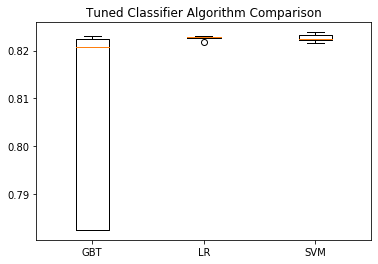

In [33]:
# Compare tuned algorithms using a boxplot chart

Tresults = [tGBTresult.cv_results_['mean_test_score'], tLRresult.cv_results_['mean_test_score'], tSVMresult.cv_results_['mean_test_score']]
Tnames = ['GBT', 'LR', 'SVM']


pyplot.boxplot(Tresults, labels=Tnames)
pyplot.title('Tuned Classifier Algorithm Comparison')
pyplot.show()

In [34]:
## MODEL EVALUATION
#Best: 0.822952 using {'C': 50, 'penalty': 'l1'}

# Predict the labels of the test set 'LRpred' using Logistic Regression Classification
t0 = time.time() #begin time keeper variable
LRmodel = LogisticRegression(penalty= 'l1', C=50, solver='liblinear', random_state=14)
LRmodel.fit(X_train, y_train.ravel())
ttt = time.time() - t0 #ttt stands for "time to train"
print("It takes: %.3f seconds for Logistic Regression Classifier fitting" % ttt)

LRpred = LRmodel.predict(X_test)
print('\nLogistic Regression Predictions')
print(LRpred)

# Compute and print metrics
print("\nLogistic Regression Accuracy: {}".format(LRmodel.score(X_test, y_test)))
print('\nClassification Report')
print(classification_report(y_test, LRpred))

#Summary metrics
print('\n***** LR Model summary metrics *****')
print("Accuracy with LR on testing set is: %.4f" % accuracy_score(y_true=y_test, y_pred=LRpred))
print("Kappa with LR on testing set is: %.4f" % cohen_kappa_score(y1=y_test, y2=LRpred))

#Save the model to disk
LRfilename = 'LRmodel.sav'
dump(LRmodel, open(LRfilename, 'wb'))
print("\n*** The model has been successfully saved as %s ***" % LRfilename)

It takes: 0.321 seconds for Logistic Regression Classifier fitting

Logistic Regression Predictions
['No' 'No' 'No' ... 'No' 'No' 'No']

Logistic Regression Accuracy: 0.813

Classification Report
              precision    recall  f1-score   support

          No       0.83      0.95      0.89      6930
         Yes       0.69      0.34      0.46      2070

    accuracy                           0.81      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.81      0.79      9000


***** LR Model summary metrics *****
Accuracy with LR on testing set is: 0.8130
Kappa with LR on testing set is: 0.3606

*** The model has been successfully saved as LRmodel.sav ***


In [35]:
# Predict the labels of the test set 'GBTpred' using Gradient Boosting Classifier
#Best: 0.823000 using {'learning_rate': 0.1, 'n_estimators': 50}

t0 = time.time() #begin time keeper variable
GBTmodel = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, random_state=14)
GBTmodel.fit(X_train, y_train.ravel())
ttt = time.time() - t0 #ttt stands for "time to train"
print("It takes: %.3f seconds for GBT Classifier fitting" % ttt)

GBTpred = GBTmodel.predict(X_test)
print('\nGradient Boosting Classifier Predictions')
print(GBTpred)

# Compute and print metrics
print("\nGBT Accuracy: {}".format(GBTmodel.score(X_test, y_test)))
print('\nClassification Report')
print(classification_report(y_test, GBTpred))

#Summary metrics
print('\n***** GBT Model summary metrics *****')
print("Accuracy with GBT on testing set is: %.4f" % accuracy_score(y_true=y_test, y_pred=GBTpred))
print("Kappa with GBT on testing set is: %.4f" % cohen_kappa_score(y1=y_test, y2=GBTpred))

#Save the model to disk
GBTfilename = 'GBTmodel.sav'
dump(GBTmodel, open(GBTfilename, 'wb'))
print("\n*** The model has been successfully saved as %s ***" % GBTfilename)

It takes: 2.016 seconds for GBT Classifier fitting

Gradient Boosting Classifier Predictions
['No' 'No' 'No' ... 'No' 'No' 'No']

GBT Accuracy: 0.8133333333333334

Classification Report
              precision    recall  f1-score   support

          No       0.83      0.95      0.89      6930
         Yes       0.69      0.34      0.46      2070

    accuracy                           0.81      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.81      0.79      9000


***** GBT Model summary metrics *****
Accuracy with GBT on testing set is: 0.8133
Kappa with GBT on testing set is: 0.3598

*** The model has been successfully saved as GBTmodel.sav ***


In [36]:
# Predict the labels of the test set 'SVMpred' using Support Vector Machines (SVM)
#Best: 0.823810 using {'C': 10, 'gamma': 0.1}

t0 = time.time() #begin time keeper variable
SVMmodel = SVC(C=10, gamma=0.1, random_state=14) #ADD TUNED PARAMETERS
SVMmodel.fit(X_train, y_train.ravel())
ttt = time.time() - t0 #ttt stands for "time to train"
print("It takes: %.3f seconds for SVM Classifier fitting" % ttt)

SVMpred = SVMmodel.predict(X_test)
print('\nSupport Vector Machines Predictions')
print(SVMpred)

# Compute and print metrics
print("\nSVM Accuracy: {}".format(SVMmodel.score(X_test, y_test)))
print('\nClassification Report')
print(classification_report(y_test, SVMpred))

#Summary metrics
print('\n***** SVM Model summary metrics *****')
print("Accuracy with SVM on testing set is: %.4f" % accuracy_score(y_true=y_test, y_pred=SVMpred))
print("Kappa with SVM on testing set is: %.4f" % cohen_kappa_score(y1=y_test, y2=SVMpred))

#Save the model to disk
SVMfilename = 'SVMmodel.sav'
dump(SVMmodel, open(SVMfilename, 'wb'))
print("\n*** The model has been successfully saved as %s ***" % SVMfilename)

It takes: 37.894 seconds for SVM Classifier fitting

Support Vector Machines Predictions
['No' 'No' 'No' ... 'No' 'No' 'No']

SVM Accuracy: 0.8133333333333334

Classification Report
              precision    recall  f1-score   support

          No       0.83      0.95      0.89      6930
         Yes       0.69      0.34      0.46      2070

    accuracy                           0.81      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.81      0.79      9000


***** SVM Model summary metrics *****
Accuracy with SVM on testing set is: 0.8133
Kappa with SVM on testing set is: 0.3608

*** The model has been successfully saved as SVMmodel.sav ***


In [ ]:
## load the models from disk
LRloaded_model = load(open(LRfilename, 'rb'))
LRresult = LRloaded_model.score(X_test, y_test)
print('\nLogistic Regression Results')
print(LRresult)

GBTloaded_model = load(open(GBTfilename, 'rb'))
GBTresult = GBTloaded_model.score(X_test, y_test)
print('\nGradient Boosting Results')
print(GBTresult)

SVMloaded_model = load(open(SVMfilename, 'rb'))
SVMresult = SVMloaded_model.score(X_test, y_test)
print('\nSupport Vector Machines Results')
print(SVMresult)